In [1]:
# import packages for initial exploration
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import json

import os

import sklearn as sk

In [2]:
# load in the training dataframe and testing
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### We are trying to predict Survived and everything else can be treated as data (besides the PassengerId)

In [9]:
# let's create two different data frame we will add to
X_train = pd.DataFrame(index=train.index)
X_test = pd.DataFrame(index=test.index)
y_train = train['Survived']

In [4]:
# let's see overall rate of nulls
null_rate = train.isna().sum() / train.shape[0]
null_rate.sort_values(ascending=False)

Cabin          0.771044
Age            0.198653
Embarked       0.002245
Fare           0.000000
Ticket         0.000000
Parch          0.000000
SibSp          0.000000
Sex            0.000000
Name           0.000000
Pclass         0.000000
Survived       0.000000
PassengerId    0.000000
dtype: float64

In [5]:
# Cabin is primarily null, what are its unique values?
train['Cabin'].nunique()

147

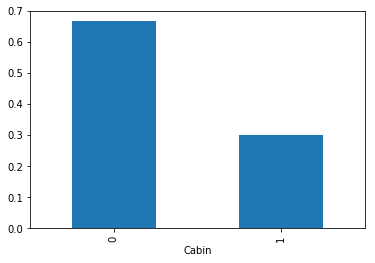

In [6]:
# there are way too many unique values - is there a difference for nulls for Survived?
train.groupby(train['Cabin'].isna().astype(int))['Survived'].mean().plot(kind='bar')

In [7]:
# makes a huge difference in survival rate! If there was a Cabin assigned, survival was 66% vs 30% for non-Cabin
# what about other values?
train['Cabin'].str.split(' ').str.len().apply(lambda x: 0 if pd.isna(x) else x).value_counts()

0.0    687
1.0    180
2.0     16
3.0      6
4.0      2
Name: Cabin, dtype: int64

In [10]:
# seems like Cabin can be turned into a simple 0/1 for null/non-null becasuse values > 1 are rare
X_train['Cabin'] = train['Cabin'].isna().astype(int)
X_test['Cabin'] = test['Cabin'].isna().astype(int)

In [12]:
# we will come back to Age, let's see Embarked
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [13]:
# what is survival rate?
train.groupby('Embarked')['Survived'].mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

In [14]:
# the difference between C and Q/S are major - we can use the dummy approach, assign the nulls to S since that's the largest size
train.loc[(train['Embarked'].isna()), 'Embarked'] = 'S'
test.loc[(test['Embarked'].isna()), 'Embarked'] = 'S'
X_train = X_train.merge(
    pd.get_dummies(train['Embarked'], prefix='Embarked', dummy_na=False, columns=['Embarked']), 
    left_index=True,
    right_index=True
)
X_test = X_test.merge(
    pd.get_dummies(test['Embarked'], prefix='Embarked', dummy_na=False, columns=['Embarked']), 
    left_index=True,
    right_index=True
)

In [21]:
# Fare - what about in population cuts?
train['Fare_qcut'], fare_qcut_bins = pd.qcut(train['Fare'], 4, retbins=True)
train.groupby('Fare_qcut').agg({'Survived': ['mean', 'count']})

Survived      
                     mean count
Fare_qcut                      
(-0.001, 7.91]   0.197309   223
(7.91, 14.454]   0.303571   224
(14.454, 31.0]   0.454955   222
(31.0, 512.329]  0.581081   222

In [39]:
# let's assign the cuts
X_train['Fare_qcut'], fare_qcut_bins = pd.qcut(train['Fare'], 4, labels=False, retbins=True)
X_test['Fare_qcut'] = pd.cut(test['Fare'], fare_qcut_bins, include_lowest=True, labels=False)

In [45]:
# let's see Ticket
train['Ticket'].head(), train['Ticket'].nunique()

(0           A/5 21171
 1            PC 17599
 2    STON/O2. 3101282
 3              113803
 4              373450
 Name: Ticket, dtype: object,
 681)

In [47]:
# there are a lot of unique values but some overlap, are those with families?
# for that, we need to create another indicator
train['Alone'] = 0
train.loc[(train['SibSp'] == 0) & (train['Parch'] == 0), 'Alone'] = 1
train['Alone'].mean()

0.6026936026936027

In [48]:
ticket_vc = train['Ticket'].value_counts()
train.loc[(train['Ticket'].isin(ticket_vc[ticket_vc > 1].index)), 'Alone'].mean()

0.2180232558139535

In [50]:
# so it seems if tickets overlap, that was an indication of being with family, but clearly there could also be shared ones
# for those the Fare should be little
train.loc[(train['Ticket'].isin(ticket_vc[ticket_vc > 1].index)) & (train['Alone'] == 1), 'Fare'].describe()
# seems like that hypothesis is false

count     75.000000
mean      73.025495
std       92.578861
min        0.000000
25%       15.300000
50%       56.495800
75%       84.829150
max      512.329200
Name: Fare, dtype: float64

In [51]:
# does the survival rate change for those groups?
train['Ticket Group'] = np.nan
train.loc[
    (train['Ticket'].isin(ticket_vc[ticket_vc == 1].index))
, 'Ticket Group'] = 'Non-Shared Ticket'
train.loc[
    (train['Ticket'].isin(ticket_vc[ticket_vc > 1].index))
    & (train['Alone'] == 1)
, 'Ticket Group'] = 'Shared Ticket & Alone'
train.loc[
    (train['Ticket'].isin(ticket_vc[ticket_vc > 1].index))
    & (train['Alone'] == 0)
, 'Ticket Group'] = 'Shared Ticket & Not Alone'
train.groupby('Ticket Group')['Survived'].mean()

Ticket Group
Non-Shared Ticket            0.297989
Shared Ticket & Alone        0.506667
Shared Ticket & Not Alone    0.524164
Name: Survived, dtype: float64

In [52]:
# there can be a variable created with shared/non-shared
X_train['Shared_Ticket'] = (train['Ticket Group'] != 'Non-Shared Ticket').astype(int)
# do the same for test
test_ticket_vc = test['Ticket'].value_counts()
test.loc[(test['Ticket'].isin(test_ticket_vc[test_ticket_vc == 1].index)), 'Ticket Group'] = 'Non-Shared Ticket'
X_test['Shared_Ticket'] = (test['Ticket Group'] != 'Non-Shared Ticket').astype(int)

In [74]:
# Parch & SibSp
train['Total Family Size'] = train['Parch'] + train['SibSp']
train.groupby('Total Family Size')['Fare'].mean()

Total Family Size
0     21.242689
1     49.894129
2     39.692482
3     54.864510
4     58.094453
5     73.722727
6     29.366667
7     46.900000
10    69.550000
Name: Fare, dtype: float64

In [77]:
# Parch and SibSp can be left as is

# Sex
X_train['Sex_female'] = (train['Sex'] == 'female').astype(int)
X_test['Sex_female'] = (test['Sex'] == 'female').astype(int)

In [110]:
# Pclass - one hot
X_train = X_train.merge(
    pd.get_dummies(train['Pclass'], prefix='Pclass', dummy_na=False, columns=['Pclass']), 
    left_index=True,
    right_index=True
)
X_test = X_test.merge(
    pd.get_dummies(test['Pclass'], prefix='Pclass', dummy_na=False, columns=['Pclass']), 
    left_index=True,
    right_index=True
)

In [81]:
# what about Age?
train.groupby(train['Age'].isna().astype(int))['Survived'].mean()

Age
0    0.406162
1    0.293785
Name: Survived, dtype: float64

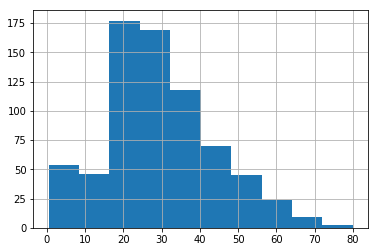

In [82]:
# null shows power in splitting our binary target - what about a more general population idea?
train['Age'].hist()
plt.show()

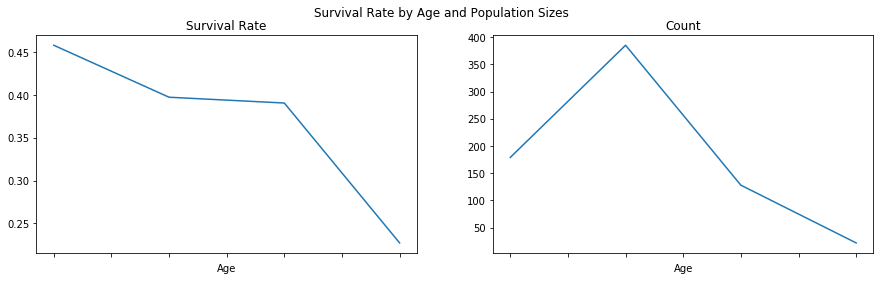

In [83]:
# what about survival rate in terms of bins of age 20?
age_bins = np.arange(start=0, stop=81, step=20)
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(15, 4))
ax = ax.flatten()
plot_g = train.groupby(pd.cut(x=train['Age'], bins=age_bins, right=True, include_lowest=True))['Survived']
plot_g.mean().plot(ax=ax[0])
ax[0].set_title('Survival Rate')
plot_g.count().plot(ax=ax[1])
ax[1].set_title('Count')
fig.suptitle('Survival Rate by Age and Population Sizes')
plt.show()

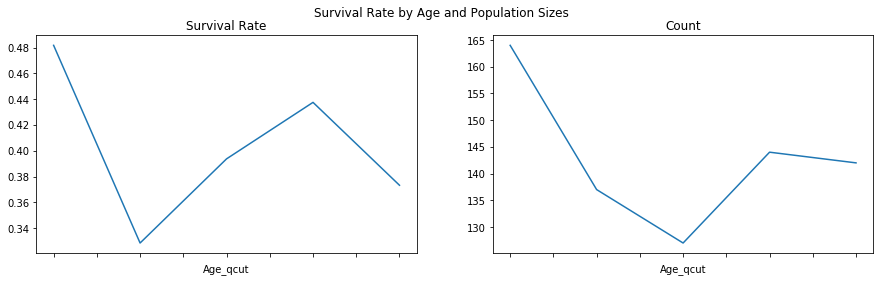

[ 0.42 19.   25.   31.8  41.   80.  ]


In [84]:
# what about survival rate in terms of population cuts? we will 5 quantiles because the population distribution won't allow for 10
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
ax = ax.flatten()
train['Age_qcut'], age_qcut_bins = pd.qcut(train['Age'], q=5, retbins=True)
plot_g = train.groupby('Age_qcut')['Survived']
plot_g.mean().plot(ax=ax[0])
ax[0].set_title('Survival Rate')
plot_g.count().plot(ax=ax[1])
ax[1].set_title('Count')
fig.suptitle('Survival Rate by Age and Population Sizes')
plt.show()
print(age_qcut_bins)

In [85]:
# the two cuts type tell a different story
# the simple cut says for ages upto 20, survival is high, 20-60 is similar, and 60 above is low
# the quct shows ages upto 19 were had high survival (supported by cut), and 
    # 20-25 had VERY low (which is different than what cut says)
# there also also population size differences - cut has wildly varying population while qcut is simiar-ish

In [86]:
# since our data sets are ready besides the Age, we can use them to directly impute
X_train['Age'] = train['Age']
X_test['Age'] = test['Age']

In [111]:
# let's check out the null values before - Fare is test is null for very few in test, we can leave it upto imputation method
pd.concat([X_test.isna().mean().rename('test'), X_train.isna().mean().rename('train')], axis=1)

,test,train
Cabin,0.000000,0.000000
Embarked_C,0.000000,0.000000
Embarked_Q,0.000000,0.000000
Embarked_S,0.000000,0.000000
Fare_qcut,0.002392,0.000000
Shared_Ticket,0.000000,0.000000
Sex_female,0.000000,0.000000
Age,0.205742,0.198653
Pclass_1,0.000000,0.000000
Pclass_2,0.000000,0.000000


In [112]:
# import an imputation method
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
# since we are using KNN, we should transform our dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train.loc[(X_train['Age'].notna())])
X_train_scaled = pd.DataFrame(scaler.transform(X_train.loc[(X_train['Age'].notna())]), columns=X_train.columns, index=X_train.loc[(X_train['Age'].notna())].index)
imputer = KNNImputer(n_neighbors=5).fit(X_train_scaled)

X_train_result = pd.DataFrame(
    imputer.transform(scaler.transform(X_train)),
    columns=X_train.columns,
    index=X_train.index
)

X_test_result = pd.DataFrame(
    imputer.transform(scaler.transform(X_test)),
    columns=X_test.columns,
    index=X_test.index
)

In [128]:
# now let's try some models
from sklearn.linear_model import LogisticRegressionCV
logit_cv = LogisticRegressionCV(1, fit_intercept=False, cv=3, penalty='l2')
logit_cv.fit(X_train_result, y_train)

D:\software-installs\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass Cs=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


LogisticRegressionCV(Cs=1, cv=3, fit_intercept=False)

In [136]:
# predict on test set
y_test = pd.Series(logit_cv.predict(X_test_result), index=X_test_result.index).rename('Survived')
# result 0.69617
pd.concat([test['PassengerId'], y_test], axis=1).to_csv('logit_cv_3.csv', index=False)

In [142]:
# let's try a Random Forest
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
random_forest = RandomForestClassifier(n_estimators=50, max_depth=3, min_samples_split=18, oob_score=True, max_samples=0.8)
random_forest.fit(X_train_result, y_train)
random_forest.oob_score_

0.7901234567901234

In [143]:
# predict on test set
y_test = pd.Series(random_forest.predict(X_test_result), index=X_test_result.index).rename('Survived')
# result 0.78229
pd.concat([test['PassengerId'], y_test], axis=1).to_csv('random_forest.csv', index=False)

In [173]:
# Gradient Boosting
gradient_boosting = GradientBoostingClassifier(
    loss='exponential',
    learning_rate=0.05,
    n_estimators=25,
    subsample=0.8,
    min_samples_split=18,
    max_depth=3,
    validation_fraction=0.2,
    n_iter_no_change=5,
    tol=1e-5
)
gradient_boosting.fit(X_train_result, y_train)
gradient_boosting.oob_improvement_, gradient_boosting.oob_improvement_.sum()

(array([0.02159814, 0.01737695, 0.015388  , 0.0177033 , 0.01326642,
        0.0108076 , 0.01556884, 0.01150727, 0.01107215, 0.01011891,
        0.0085575 , 0.00676486, 0.0066742 , 0.00748433, 0.00615612,
        0.00402141, 0.00521664, 0.00545127, 0.00264499, 0.00270322,
        0.00233271, 0.00341432, 0.00391682, 0.00328167, 0.00287035]),
 0.21589796414981188)

In [174]:
# predict on test set
y_test = pd.Series(gradient_boosting.predict(X_test_result), index=X_test_result.index).rename('Survived')
# result 0.77033, 0.77751
pd.concat([test['PassengerId'], y_test], axis=1).to_csv('gradient_boosting_exp.csv', index=False)

In [185]:
# what about a simple KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
knn = KNeighborsClassifier(
    n_neighbors=18,
    weights='distance'
)
cross_validate(estimator=knn, X=X_train_result, y=y_train, scoring='accuracy', cv=10)

{'fit_time': array([0.00599957, 0.00405598, 0.00405407, 0.00405765, 0.00305367,
        0.00299907, 0.00300026, 0.00400043, 0.00394583, 0.00299931]),
 'score_time': array([0.00400329, 0.00294518, 0.00294304, 0.00294352, 0.00300074,
        0.00399995, 0.00300002, 0.00299931, 0.00304604, 0.00299883]),
 'test_score': array([0.75555556, 0.82022472, 0.76404494, 0.80898876, 0.82022472,
        0.75280899, 0.78651685, 0.79775281, 0.80898876, 0.7752809 ])}

In [186]:
knn.fit(X_train_result, y_train)
# predict on test set
y_test = pd.Series(knn.predict(X_test_result), index=X_test_result.index).rename('Survived')
# result 0.72727... bad
pd.concat([test['PassengerId'], y_test], axis=1).to_csv('knn.csv', index=False)